In [1]:
import json
import random

In [2]:
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\fifth_epoch_entities.txt', 'r', encoding='utf-8') as f:
    entity_list = eval(f.read())

In [3]:
entity_dict = dict()
for i in entity_list:
    entity_dict[i[0]] = i[1]

In [4]:
len(entity_dict)

1472

In [15]:
import matplotlib.pyplot as plt

from collections import Counter



value_counts = Counter(entity_dict.values())
value_counts

Counter({'TECH': 387,
         'COMP': 382,
         'STOR': 170,
         'DATA': 133,
         'INST': 105,
         'ARCH': 71,
         'IO': 61,
         'PERF': 54,
         'PROG': 52,
         'CORP': 17,
         'ALG': 16,
         'PROT': 15,
         'PER': 4,
         'GRP': 4,
         'LOC': 1})

In [3]:
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_trainset_v5.json', 'r', encoding='utf-8') as f:
    first_epoch_trainset = json.loads(f.read())

In [4]:
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\test_set_v5.json', 'r', encoding='utf-8') as f:
    test_set = json.loads(f.read())
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\validset_v5.json', 'r', encoding='utf-8') as f:
    validset = json.loads(f.read())

In [6]:
# with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\trainset\second_epoch_trainset.json', 'r', encoding='utf-8') as f:
#     second_epoch_trainset = json.loads(f.read())
# with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\trainset\third_epoch_trainset.json', 'r', encoding='utf-8') as f:
#     third_epoch_trainset = json.loads(f.read())
# with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\trainset\forth_epoch_trainset.json', 'r', encoding='utf-8') as f:
#     forth_epoch_trainset = json.loads(f.read())
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\trainset\fifth_epoch_trainset.json', 'r', encoding='utf-8') as f:
    fifth_epoch_trainset = json.loads(f.read())

In [7]:
import re

def update_label(dataset: dict, entity_dict: dict):
    """更新数据集标签
    Args:
        dataset (dict): 数据集
        entity_dict (dict): 实体词典
    """

    for i, labels in enumerate(dataset['labels']):
        text = dataset['corpus'][i]
        existing_spans = {label['span'] for label in labels['output']}

        # 更新已有的标签，并删除不在entity_dict中的标签
        new_output = []
        for label in labels['output']:
            span = label['span']
            if span in entity_dict:
                # 更新type
                label['type'] = entity_dict[span]
                # 更新start和end
                # 这里有问题
                # 假设句子里有多个相同实体，那么这个find会多次返回第一个匹配实体的位置，导致重叠
                # 使用正则表达式找到所有匹配的位置
                for match in re.finditer(re.escape(span), text):
                    start = match.start()
                    end = match.end()
                    if not any(start < l['end'] and end > l['start'] for l in new_output):
                        label['start'] = start
                        label['end'] = end
                        label['span'] = span
                        new_output.append(label)
                        break  # 只更新第一个匹配的位置
        labels['output'] = new_output

        # 按照长度排序实体词典，确保最长的实体优先匹配
        sorted_entities = sorted(entity_dict.items(), key=lambda item: len(item[0]), reverse=True)

        # 添加未识别出的实体标签
        for span, entity_type in sorted_entities:
            # 使用正则表达式匹配所有结果
            for match in re.finditer(re.escape(span), text):
                start = match.start()
                end = match.end()
                overlap = False
                for label in labels['output']:
                    if (start < label['end'] and end > label['start']):
                        overlap = True
                        break
                if not overlap:
                    new_label = {
                        'type': entity_type,
                        'start': start,
                        'end': end,
                        'prob': 0.0,  # 可以根据需要设置默认值
                        'span': span
                    }
                    labels['output'].append(new_label)


In [7]:
update_label(test_set, entity_dict)
update_label(validset, entity_dict)

In [8]:
update_label(first_epoch_trainset, entity_dict)

In [8]:
# update_label(second_epoch_trainset, entity_dict)
# update_label(third_epoch_trainset, entity_dict)
# update_label(forth_epoch_trainset, entity_dict)
update_label(fifth_epoch_trainset, entity_dict)

In [9]:
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\test_set_v6.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(test_set))

In [10]:
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\validset_v6.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(validset))

In [12]:
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_trainset_v6.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(first_epoch_trainset))

In [ ]:
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_trainset_v3.json', 'r', encoding='utf-8') as f:
    first_epoch_trainset_v3 = json.loads(f.read())

In [9]:
# with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\trainset\second_epoch_trainset_v2.json', 'w', encoding='utf-8') as f:
#     f.write(json.dumps(second_epoch_trainset))
# with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\trainset\third_epoch_trainset_v2.json', 'w', encoding='utf-8') as f:
#     f.write(json.dumps(third_epoch_trainset))
# with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\trainset\forth_epoch_trainset_v2.json', 'w', encoding='utf-8') as f:
#     f.write(json.dumps(forth_epoch_trainset))
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\trainset\fifth_epoch_trainset_v2.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(fifth_epoch_trainset))

In [ ]:
entity_set = set()
for i, row in enumerate(first_epoch_trainset_v3):
    if row.get('label'):
        entities = [label['text'] for label in row['label']]
        entities_type = [label['labels'][0] for label in row['label']]
        for item in dict(zip(entities, entities_type)).items():
            entity_set.add(item)
    else:
        continue

In [ ]:
entity_list = list(entity_set)
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_entities.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(entity_list))
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_entities.txt', 'w', encoding='utf-8') as f:
    f.write(str(entity_list))

In [ ]:
# validset 标记完之后，更新词典
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_entities.txt', 'r', encoding='utf-8') as f:
    first_epoch_entities = set(eval(f.read()))
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\validset_v3.json', 'r', encoding='utf-8') as f:
    validset_v3 = json.loads(f.read())

for i, row in enumerate(validset_v3):
    if row.get('label'):
        entities = [label['text'] for label in row['label']]
        entities_type = [label['labels'][0] for label in row['label']]
        for item in dict(zip(entities, entities_type)).items():
            first_epoch_entities.add(item)
    else:
        continue

with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_entities.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(list(first_epoch_entities)))
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_entities.txt', 'w', encoding='utf-8') as f:
    f.write(str(first_epoch_entities))

In [2]:
# second_epoch_trainset 标记完之后，更新词典
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_entities.txt', 'r', encoding='utf-8') as f:
    first_epoch_entities = set(eval(f.read()))
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\trainset\second_epoch_trainset_v3.json', 'r', encoding='utf-8') as f:
    second_epoch_trainset_v3 = json.loads(f.read())

for i, row in enumerate(second_epoch_trainset_v3):
    if row.get('label'):
        entities = [label['text'] for label in row['label']]
        entities_type = [label['labels'][0] for label in row['label']]
        for item in dict(zip(entities, entities_type)).items():
            first_epoch_entities.add(item)
    else:
        continue

with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\second_epoch_entities.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(list(first_epoch_entities)))
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\second_epoch_entities.txt', 'w', encoding='utf-8') as f:
    f.write(str(first_epoch_entities))

In [13]:
# third_epoch_trainset 标记完之后，更新词典
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\second_epoch_entities.txt', 'r', encoding='utf-8') as f:
    second_epoch_entities = set(eval(f.read()))
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\trainset\third_epoch_trainset_v3.json', 'r', encoding='utf-8') as f:
    third_epoch_trainset_v3 = json.loads(f.read())

for i, row in enumerate(third_epoch_trainset_v3):
    if row.get('label'):
        entities = [label['text'] for label in row['label']]
        entities_type = [label['labels'][0] for label in row['label']]
        for item in dict(zip(entities, entities_type)).items():
            second_epoch_entities.add(item)
    else:
        continue

with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\third_epoch_entities.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(list(second_epoch_entities)))
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\third_epoch_entities.txt', 'w', encoding='utf-8') as f:
    f.write(str(second_epoch_entities))

In [2]:
# forth_epoch_trainset 标记完之后，更新词典
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\third_epoch_entities.txt', 'r', encoding='utf-8') as f:
    third_epoch_entities = set(eval(f.read()))
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\trainset\forth_epoch_trainset_v3.json', 'r', encoding='utf-8') as f:
    forth_epoch_trainset_v3 = json.loads(f.read())

for i, row in enumerate(forth_epoch_trainset_v3):
    if row.get('label'):
        entities = [label['text'] for label in row['label']]
        entities_type = [label['labels'][0] for label in row['label']]
        for item in dict(zip(entities, entities_type)).items():
            third_epoch_entities.add(item)
    else:
        continue

with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\forth_epoch_entities.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(list(third_epoch_entities)))
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\forth_epoch_entities.txt', 'w', encoding='utf-8') as f:
    f.write(str(third_epoch_entities))

In [2]:
# fifth_epoch_trainset 标记完之后，更新词典
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\forth_epoch_entities.txt', 'r', encoding='utf-8') as f:
    forth_epoch_entities = set(eval(f.read()))
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\trainset\fifth_epoch_trainset_v3.json', 'r', encoding='utf-8') as f:
    fifth_epoch_trainset_v3 = json.loads(f.read())

for i, row in enumerate(fifth_epoch_trainset_v3):
    if row.get('label'):
        entities = [label['text'] for label in row['label']]
        entities_type = [label['labels'][0] for label in row['label']]
        for item in dict(zip(entities, entities_type)).items():
            forth_epoch_entities.add(item)
    else:
        continue

with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\fifth_epoch_entities.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(list(forth_epoch_entities)))
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\fifth_epoch_entities.txt', 'w', encoding='utf-8') as f:
    f.write(str(forth_epoch_entities))

In [ ]:
# 转换标记完之后的数据
# 该函数只对first_epoch_trainset_v3、testset_v3、validset_v3进行处理，其他数据集请勿使用
def jsonMin2Original(json_min_filename: str, output_filename: str):
    with open(json_min_filename, 'r', encoding='utf-8') as json_file:
        json_min = json.loads(json_file.read())

    output = {
            'corpus': [],
            'labels': []
        }
    for item in json_min:
        output['corpus'].append(item['text'])
        new_item = {'output': []}
        if item.get('label'):
            for label in item['label']:
                new_item['output'].append(
                        {
                            'type': label['labels'][0],
                            "start": label["start"],
                            "end": label["end"],
                            "prob": None,
                            "span": label["text"]
                        }
                    )
        output['labels'].append(new_item)

    with open(output_filename, 'w', encoding='utf-8') as output_file:
        output_file.write(json.dumps(output))


jsonMin2Original(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_trainset_v3.json', r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_trainset_v5.json')
jsonMin2Original(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\validset_v3.json', r'G:\python_codes\Principles_of_Computer_Construction_KG\output\validset_v5.json')
jsonMin2Original(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\test_set_v3.json', r'G:\python_codes\Principles_of_Computer_Construction_KG\output\test_set_v5.json')

In [2]:
def process_labels_by_BIOES(dataset: list):
    new_dataset = []
    for i, row in enumerate(dataset):
        tmp = ['O'] * len(row['text'])
        if row.get('label'):
            labels = row['label']
            for label in labels:
                start, end, label_type = label['start'], label['end'], label['labels'][0]
                if end - start == 1:
                    tmp[start] = f'S-{label_type}'
                else:
                    tmp[start] = f'B-{label_type}'
                    for idx in range(start + 1, end - 1):
                        tmp[idx] = f'I-{label_type}'
                    tmp[end - 1] = f'E-{label_type}'
        new_dataset.append(
            {
                'text': row['text'],
                'labels': tmp
            }
        )

    return new_dataset

In [3]:
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\trainset\ner_trainset_v1.json', 'r') as f:
    ner_trainset = json.loads(f.read())
ner_trainset_v2 = process_labels_by_BIOES(ner_trainset)
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\trainset\ner_trainset_v2.json', 'w') as f:
    f.write(json.dumps(ner_trainset_v2))

In [4]:
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_trainset_v7.json', 'r', encoding='utf-8')as f:
    first_epoch_trainset_v7 = json.loads(f.read())
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\validset_v7.json', 'r', encoding='utf-8')as f:
    validset_v7 = json.loads(f.read())
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\test_set_v7.json', 'r', encoding='utf-8')as f:
    test_set_v7 = json.loads(f.read())

with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_trainset_v8.json', 'w', encoding='utf-8')as f:
    first_epoch_trainset_v8 = f.write(json.dumps(process_labels_by_BIOES(first_epoch_trainset_v7)))
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\validset_v8.json', 'w', encoding='utf-8')as f:
    validset_v8 = f.write(json.dumps(process_labels_by_BIOES(validset_v7)))
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\test_set_v8.json', 'w', encoding='utf-8')as f:
    test_set_v8 = f.write(json.dumps(process_labels_by_BIOES(test_set_v7)))

In [ ]:
first_epoch_trainset_v4 = process_labels_by_BIOES(first_epoch_trainset_v3)

In [ ]:
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_trainset_v4.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(first_epoch_trainset_v4))

In [ ]:
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\validset_v3.json', 'r', encoding='utf-8') as f:
    validset_v3 = json.loads(f.read())
validset_v4 = process_labels_by_BIOES(validset_v3)
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\validset_v4.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(validset_v4))

In [ ]:
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_trainset_v4.json', 'r', encoding='utf-8') as f:
    first_epoch_trainset_v4 = json.loads(f.read())
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\validset_v4.json', 'r', encoding='utf-8') as f:
    validset_v4 = json.loads(f.read())

In [ ]:
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\test_set_v3.json', 'r', encoding='utf-8') as f:
    test_set_v3 = json.loads(f.read())
test_set_v4 = process_labels_by_BIOES(test_set_v3)

In [ ]:
with open(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\test_set_v4.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(test_set_v4))

In [6]:
def json2conll(source, target):
    with open(source, "r", encoding="utf-8") as json_file:
        data_list = json.loads(json_file.read())

    conll_format = ""

    for data in data_list:
        text = data["text"]
        labels = data["labels"]

        for char, label in zip(text, labels):
            conll_format += f"{char}\t{label}\n"

        conll_format += "\n"  # Add a newline to separate sentences

    with open(target, 'w', encoding='utf-8') as conll:
        conll.write(conll_format)

In [ ]:
json2conll(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_trainset_v4.json', r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_trainset_v4.txt')
json2conll(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\validset_v4.json', r'G:\python_codes\Principles_of_Computer_Construction_KG\output\validset_v4.txt')

In [ ]:
json2conll(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\test_set_v4.json', r'G:\python_codes\Principles_of_Computer_Construction_KG\output\test_set_v4.txt')

In [7]:
json2conll(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_trainset_v8.json', r'G:\python_codes\Principles_of_Computer_Construction_KG\output\first_epoch_trainset_v8.txt')
json2conll(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\validset_v8.json', r'G:\python_codes\Principles_of_Computer_Construction_KG\output\validset_v8.txt')
json2conll(r'G:\python_codes\Principles_of_Computer_Construction_KG\output\test_set_v8.json', r'G:\python_codes\Principles_of_Computer_Construction_KG\output\test_set_v8.txt')

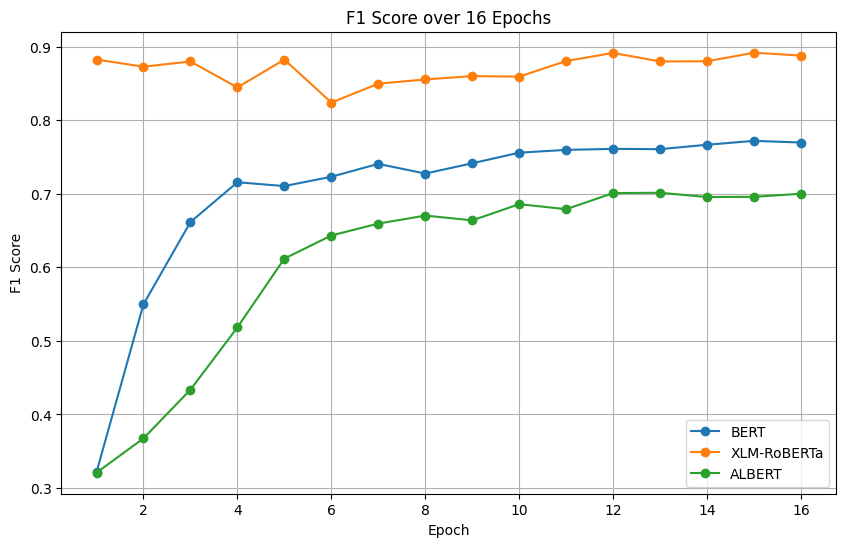

In [1]:
import matplotlib.pyplot as plt

# 数据
epochs = list(range(1, 17))
bert_f1 = [0.3215, 0.5498, 0.6616, 0.7157, 0.7105, 0.7232, 0.7407, 0.7275, 0.7415, 0.7559, 0.7597, 0.7611, 0.7607, 0.7667, 0.7720, 0.7697]
xlm_roberta_f1 = [0.8825, 0.8728, 0.8799, 0.8446, 0.8825, 0.8240, 0.8497, 0.8555, 0.8600, 0.8593, 0.8805, 0.8915, 0.8799, 0.8802, 0.8918, 0.8879]
albert_f1 = [0.3208, 0.3675, 0.4337, 0.5184, 0.6119, 0.6433, 0.6595, 0.6704, 0.6639, 0.6859, 0.6791, 0.7010, 0.7014, 0.6956, 0.6959, 0.7001]

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(epochs, bert_f1, marker='o', label='BERT')
plt.plot(epochs, xlm_roberta_f1, marker='o', label='XLM-RoBERTa')
plt.plot(epochs, albert_f1, marker='o', label='ALBERT')

# 添加标题和标签
plt.title('F1 Score over 16 Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

# 显示图形
plt.show()
